# 3 Optimización de Hiperpárametros

## 3.01 Introduccion
En general los algoritmos que generan modelos predictivos poseen hiperparámetros que *dado un dataset* deben ser optimizados.
<br> La invocación de uno de esos algoritmos sin hiperparámetros no es más que
invocarlos con hiperparámetros por default definidos por el fabricante. Por ejemplo en el caso de la librería **rpart** es cp=0.01, maxdepth=30, minsplit=20, minbucket=6,  lo que en nuestro dataset genera un arbol de un solo nodo (decimos "no se abre el arbol"); la razon de esto es la proporcion de "BAJA+1" y "BAJA+2"

En el primer notebook de la asignatura usted probó optimizar manualmente los hiperparámetros entrenando en un mes completo y viendo los resultados directamente en el Public Leaderboard, que es una porción de los datos de futuro.
<br> En el mundo real no se dispone jamás de la clase del futuro, con lo cual lo anterior es meramente un artifical divertimento.
<br> La solución es estimar la bondad de un set de hiperparámetros en alguna combinación de:
  * Una sola partición de  <training, testing>
  * Multiples particiones de <training, testing>
  * El método de  k-fold Cross Validation , generalmente con n>=5
  * Utilizar   n-repated  k-fold Cross Validation
  * Leave One Out  si la cardinalidad del dataset y el poder de cómputo se lo permiten

Luego de comenzar a trabajar con el método de  "Multiples particiones de <training, testing>  se le invitó a extender un esqueleto de código del método de **Optimización de Hiperparámetros por Grid Search**

## 3.02 Conceptos

En esta entrega veremos los siguiente conceptos:
* El origen del overfitting en un arbol de decisión
* *La maldición del ganador*, overfitting en los hiperparámetros ganadores, Selective Inference
* Data Drifting
* Alterntivas de búsqueda
  * Grid Search, la fuerza bruta
  * Bayesian Optimization, la heurística

## 3.03  Corrida notebook inicial

En el repositorio oficial de la asignatura se encuentra el notebook ./src/rpart/z102_FinalTrain.ipynb  que automaticamente hace el submit a la Competencia Analista Sr  de Kaggle.
<br>  Ingrese a un nuevo Google Colab  y pruebe algunas corridas del notebook cambiando los hiperparámetros de rpart

## 3.04 Origen del Overfitting en un arbol de decisión
¿Qué combinacion de hiperparámetros overfitea un árbol de decisión, para nuestro dataset?
<br>¿Cómo se ve el overfitting desde el punto de vista de las curvas de ganancia?

El objetivo de este capítulo es que usted juegue manualmente con los hiperparámetros de un rpart, observe las curvas de ganancia generadas en una particion <training=50%, testing=50%>  y obtengla conclusiones sobre el fenómeno observado.

Introducimos el concepto de **Curva de Ganancia**
<br> Al aplicar un modelo a un dataset se le asigna a cada registro una probabilidad, a su vez cada registro contribuye con una ganancia la que puede ser una pérdida o una ganancia.  
<br>Ordenamos el dataset por probabilidad *descendente* y computamos la ganancia acumulada, generando de esta forma la curva de ganancia
<br> Para visualizar el efecto del under/over  fitting adecuadamente, realizamos una particion  <training= 50%, testing= 50%>



tener presente:
<br> Overfitting  **NO**  es la diferencia entre las curvas
<br> Lo que divide el underfitting del overfitting al aumentar la complejidad del modelo es la complejidad donde se alcanza la métrica máxima.

### ¿Qué debe hacer usted?
Probar al menos estas combinaciones:
* **Arbol crecimiento descontrolado**
   * cp= -1
   * maxdepth= 30
   * minsplit= 2
   * minbucket= 1
* Arbol talla reducida
   * cp= -1
   * maxdepth= 3
   * minsplit= 20000
   * minbucket= 10000


#### Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Type -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [ ]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   Bajar el  **competencia_01_crudo**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab



In [ ]:
%%shell

mkdir -p "/content/.drive/My Drive/dmeyf"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/dmeyf" /content/buckets/b1


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/competencia_01_crudo.csv"
archivo_destino="/content/datasets/competencia_01_crudo.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/competencia_01_crudo.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


## Generacion de la clase_ternaria

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

In [13]:
require( "data.table" )

# leo el dataset
dataset <- fread("../../Competencia 01/competencia_01_crudo.csv" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
    "pos" = .I,
    numero_de_cliente,
    periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 ) ]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
    shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente ]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
    ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
    clase_ternaria := "BAJA+1" ]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
    & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
    clase_ternaria := "BAJA+2" ]


# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

fwrite( dataset,
    file =  "./competencia_01.csv.gz",
    sep = ","
)

In [18]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

foto_mes,clase_ternaria,N
<int>,<chr>,<int>
202104,BAJA+1,955
202104,BAJA+2,1130
202104,CONTINUA,161333


Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [19]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2196062,117.3,4334505,231.5,3089593,165.1
Vcells,3967057,30.3,233852900,1784.2,365365722,2787.6


In [20]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("ggplot2")

Cargando paquete requerido: ggplot2



In [21]:
if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

In [ ]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp304"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

### Acción :  Jugar con  minsplit, minbucket y maxdepth

In [23]:
# cambiar aqui los parametros
PARAM <- list()
PARAM$semilla_primigenia <- 200003

PARAM$cp <- -1
PARAM$minsplit <- 2
PARAM$minbucket <- 1
PARAM$maxdepth <- 30

In [24]:
# particionar agrega una columna llamada fold a un dataset
#   que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(data, division, agrupa= "", campo= "fold", start= 1, seed= NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(
    function(x, y) {rep(y, x)},division, seq(from= start, length.out= length(division))))

  data[, (campo) := sample(rep(bloque,ceiling(.N / length(bloque))))[1:.N],by= agrupa]
}


In [25]:
# lectura del dataset
dataset <- fread("./competencia_01.csv.gz")

In [26]:
# a partir de ahora solo trabajo con 202104, el mes que tiene clase

dataset <- dataset[foto_mes == 202104] # defino donde voy a entrenar

In [27]:
# La division training/testing es 50%, 50%
#  que sea 50/50 se indica con el c(1,1)

particionar(dataset,
  division= c(1, 1),
  agrupa= "clase_ternaria",
  seed= PARAM$semilla_primigenia
)

In [28]:
# Entreno el modelo
# los datos donde voy a entrenar
# aqui es donde se deben probar distintos hiperparametros

modelo <- rpart(
  formula= "clase_ternaria ~ . -fold",
  data= dataset[fold == 1, ],
  xval= 0,
  cp= -1,
  minsplit= PARAM$minsplit,
  minbucket= PARAM$minbucket,
  maxdepth= PARAM$maxdepth
)

In [29]:
# aplico el modelo a TODOS los datos, inclusive los de training
prediccion <- predict(modelo, dataset, type= "prob")

In [30]:
# Pego la probabilidad de  BAJA+2
tb_prediccion <- dataset[, list(fold,clase_ternaria)]
tb_prediccion[, prob_baja2 := prediccion[, "BAJA+2"]]

In [31]:
# Dibujo la curva de ganancia acumulada
setorder(tb_prediccion, fold, -prob_baja2)

In [32]:
# agrego una columna que es la de las ganancias
# la multiplico por 2 para que ya este normalizada
#  es 2 porque cada fold es el 50%

tb_prediccion[, gan := 2 *ifelse(clase_ternaria == "BAJA+2", 780000, -20000)]
tb_prediccion[, ganancia_acumulada := cumsum(gan), by= fold]
tb_prediccion[, pos := sequence(.N), by= fold]

In [33]:
tb_prediccion

fold,clase_ternaria,prob_baja2,gan,ganancia_acumulada,pos
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1,BAJA+2,1,1560000,1560000,1
1,BAJA+2,1,1560000,3120000,2
1,BAJA+2,1,1560000,4680000,3
1,BAJA+2,1,1560000,6240000,4
1,BAJA+2,1,1560000,7800000,5
1,BAJA+2,1,1560000,9360000,6
1,BAJA+2,1,1560000,10920000,7
1,BAJA+2,1,1560000,12480000,8
1,BAJA+2,1,1560000,14040000,9


In [34]:
# agrego una columna que es la de las ganancias
# la multiplico por 2 para que ya este normalizada
#  es 2 porque cada fold es el 50%

tb_prediccion[, gan := 2 *ifelse(clase_ternaria == "BAJA+2", 780000, -20000)]
tb_prediccion[, ganancia_acumulada := cumsum(gan), by= fold]
tb_prediccion[, pos := sequence(.N), by= fold]

In [35]:
# defino hasta donde muestra el grafico
amostrar <- 20000

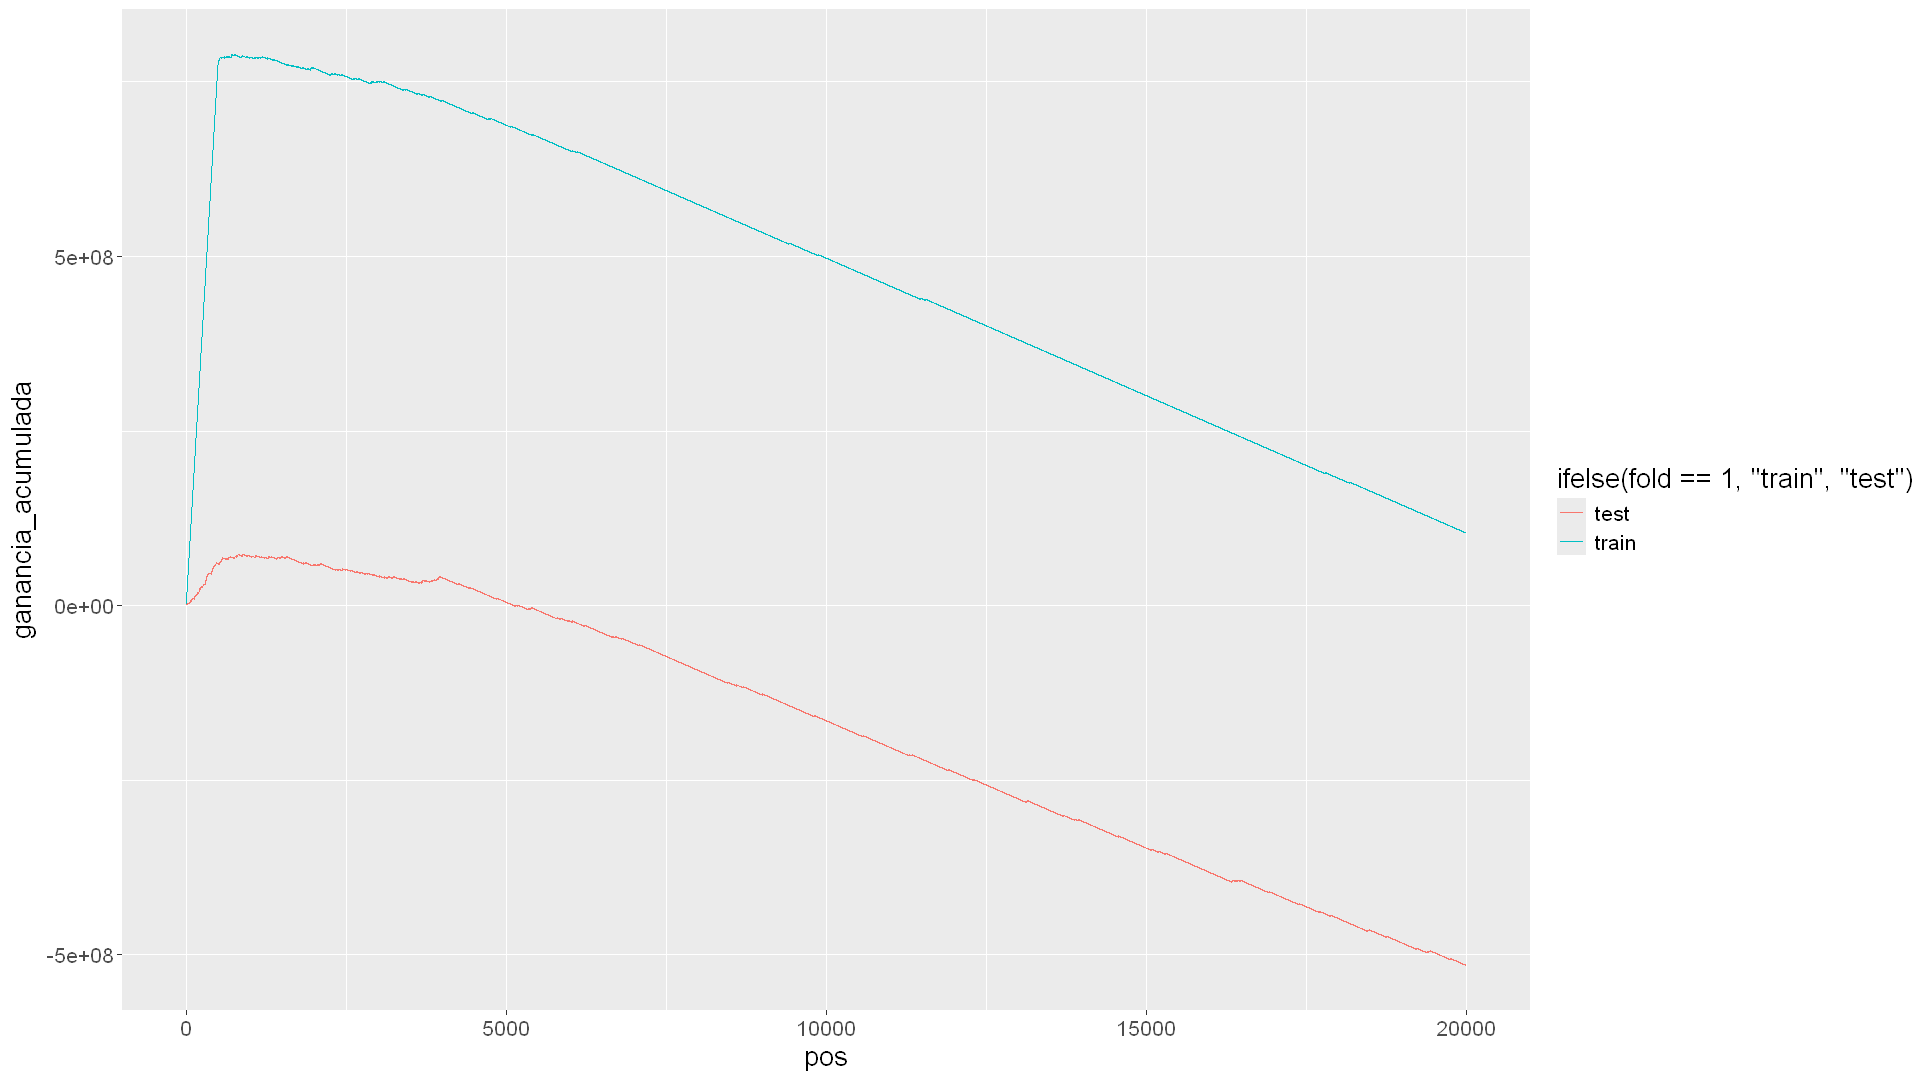

In [36]:
# Esta hermosa curva muestra como en el mentiroso training
#   la ganancia es siempre mejor que en el real testing

options( repr.plot.width=10, repr.plot.height=10)

gra <- ggplot(
           data= tb_prediccion[pos <= amostrar],
           aes( x= pos, y= ganancia_acumulada,
                color= ifelse(fold == 1, "train", "test") )
             ) + geom_line()

gra <- gra + theme(text = element_text(size = 16))

options(repr.plot.width=16, repr.plot.height=9)
print( gra )


In [37]:
# veo los resultados

print(PARAM)
cat( "Train gan max: ", tb_prediccion[fold==1, max(ganancia_acumulada)], "\n" )
cat( "Test  gan max: ", tb_prediccion[fold==2, max(ganancia_acumulada)], "\n" )


$semilla_primigenia
[1] 200003

$cp
[1] -1

$minsplit
[1] 2

$minbucket
[1] 1

$maxdepth
[1] 30

Train gan max:  7.89e+08 
Test  gan max:  73480000 


## 3.05 Análisis de la salida de Grid Search

En clase utilizando un enfoque constructivista de educacion cada una de las mesas del aula analizará las salidas de las corridas de Grid Search de la Tarea para el Hogar.
<br>Se espera que quienes ya trabajan como Data Analyst se luzcan en el análisis de esos datos
<br>Finalmente se utilizara un *arma conceptual secreta*, iluminando elegantemente donde están las mayores ganancias.

<br><br>Si debido a los avatares de la vida adulta usted no tuvo la oportunidad de generar sus propias corridas de Grid Search, con el propósito que pueda participar de la Clase 03 esta cátedra pone a su diposición la siguiente salida https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/gridsearch.txt   que estará recién disponible una hora antes de la clase

## 3.06 La Maldición del Ganador

¿Los hiperparámetros ganadores de toda la cohorte, estan overfiteando?
<br> Trabajaremos con la hoja **C3-GS Overfitting** de la Google Sheet Colaborativa
<br> Determinar de toda la cohorte quien obtuvo la mayor ganancia y con qué hiperparámetros
<br> copiarlos  a la hoja **C3-GS Overfitting**
<br> Quien obtuvo esa ganancia no debe hacer nada
<br> El resto de la cohorte, modifica su script de Grid Search para calcular la ganancia de dichos hiperparámetros ganadores  utilizando su Semilla Primigenia y registra la ganancia en la linea correspondiente a su nombre en la hoja C3-GS Overfitting

¿ Como compara la ganancia del ganador versus el resto de las ganancias recién calculadas ?

#### Bibliografia

* Selective Inference - the silent killer of replicability   https://www.youtube.com/watch?v=6ZxIzVjV1DE
* Ioannidis, J. P. A. Why most published research findings are false. PLoS Med. 2, e124 (2005). https://journals.plos.org/plosmedicine/article/file?id=10.1371/journal.pmed.0020124&type=printable



---



## 3.07 Bayesian Optimization

Se explicará en clase como a partir del Grid Search se deriva el algoritmo de Bayesian Optimization



---



## 3.08 Bayesian Optimization código

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [1]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,647797,34.6,1431195,76.5,1339936,71.6
Vcells,1197835,9.2,8388608,64.0,1963171,15.0


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [2]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

Cargando paquete requerido: data.table

Cargando paquete requerido: rpart

Cargando paquete requerido: parallel



In [3]:
if( ! require("rlist") ) install.packages("rlist")
require("rlist")

Cargando paquete requerido: rlist

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"no hay paquete llamado 'rlist'"
Installing package into 'C:/Users/nacho/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)

also installing the dependency 'XML'




package 'XML' successfully unpacked and MD5 sums checked
package 'rlist' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\nacho\AppData\Local\Temp\RtmpgFcXhA\downloaded_packages


Cargando paquete requerido: rlist



In [4]:
if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

Cargando paquete requerido: R.utils

Cargando paquete requerido: R.oo

Cargando paquete requerido: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Adjuntando el paquete: 'R.oo'


The following object is masked from 'package:R.methodsS3':

    throw


The following objects are masked from 'package:methods':

    getClasses, getMethods


The following objects are masked from 'package:base':

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Adjuntando el paquete: 'R.utils'


The following object is masked from 'package:utils':

    timestamp


The following objects are masked from 'package:base':

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings




In [5]:
# paquete necesarios para la Bayesian Optimization
if( !require("DiceKriging") ) install.packages("DiceKriging")
require("DiceKriging")

Cargando paquete requerido: DiceKriging

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"no hay paquete llamado 'DiceKriging'"
Installing package into 'C:/Users/nacho/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'DiceKriging' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\nacho\AppData\Local\Temp\RtmpgFcXhA\downloaded_packages


Cargando paquete requerido: DiceKriging



In [6]:
# paquete necesarios para la Bayesian Optimization
if( !require("mlrMBO") ) install.packages("mlrMBO")
require("mlrMBO")

Cargando paquete requerido: mlrMBO

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"no hay paquete llamado 'mlrMBO'"
Installing package into 'C:/Users/nacho/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)

also installing the dependencies 'fastmatch', 'RcppArmadillo', 'mlr', 'ParamHelpers', 'smoof', 'BBmisc', 'checkmate', 'parallelMap'




package 'fastmatch' successfully unpacked and MD5 sums checked
package 'RcppArmadillo' successfully unpacked and MD5 sums checked
package 'mlr' successfully unpacked and MD5 sums checked
package 'ParamHelpers' successfully unpacked and MD5 sums checked
package 'smoof' successfully unpacked and MD5 sums checked
package 'BBmisc' successfully unpacked and MD5 sums checked
package 'checkmate' successfully unpacked and MD5 sums checked
package 'parallelMap' successfully unpacked and MD5 sums checked
package 'mlrMBO' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\nacho\AppData\Local\Temp\RtmpgFcXhA\downloaded_packages


Cargando paquete requerido: mlrMBO

Cargando paquete requerido: mlr

Cargando paquete requerido: ParamHelpers


Adjuntando el paquete: 'ParamHelpers'


The following object is masked from 'package:R.utils':

    isVector



Adjuntando el paquete: 'mlr'


The following objects are masked from 'package:R.utils':

    resample, setThreshold


Cargando paquete requerido: smoof

Cargando paquete requerido: checkmate


Adjuntando el paquete: 'checkmate'


The following object is masked from 'package:DiceKriging':

    checkNames


The following object is masked from 'package:R.utils':

    asInt



Adjuntando el paquete: 'smoof'


The following objects are masked from 'package:R.oo':

    getDescription, getName




Accion a realizar : cambiar por su semilla primigenia

In [7]:
# Defino parametros
PARAM <- list()

PARAM$semilla_primigenia <- 200003
PARAM$experimento <- "HT308"

PARAM$BO_iter <- 40 # cantidad de iteraciones de la Bayesian Optimization

# la letra L al final de 1L significa ENTERO
PARAM$hs <- makeParamSet(
    makeNumericParam("cp", lower= -1, upper= 0.1),
    makeIntegerParam("minsplit", lower= 1L, upper= 8000L),
    makeIntegerParam("minbucket", lower= 1L, upper= 4000L),
    makeIntegerParam("maxdepth", lower= 3L, upper= 20L),
    forbidden= quote(minbucket > 0.5 * minsplit)
)
# minbuket NO PUEDE ser mayor que la mitad de minsplit



In [ ]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
dir.create(PARAM$experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", PARAM$experimento ))

In [8]:
particionar <- function(data, division, agrupa = "", campo = "fold",
                        start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(
    function(x, y) {
      rep(y, x)
    }, division,
    seq(from= start, length.out= length(division))
  ))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by= agrupa
  ]
}


In [9]:
# fold_test  tiene el numero de fold que voy a usar para testear,
#  entreno en el resto de los folds
# param tiene los hiperparametros del arbol

ArbolSimple <- function(fold_test, param_rpart) {
  # genero el modelo
  # entreno en todo MENOS el fold_test que uso para testing
  modelo <- rpart("clase_ternaria ~ .",
    data= dataset[fold != fold_test, ],
    xval= 0,
    control= param_rpart
  )

  # aplico el modelo a los datos de testing
  # aplico el modelo sobre los datos de testing
  # quiero que me devuelva probabilidades
  prediccion <- predict(modelo,
    dataset[fold == fold_test, ],
    type= "prob"
  )

  # esta es la probabilidad de baja
  prob_baja2 <- prediccion[, "BAJA+2"]

  # calculo la ganancia
  ganancia_testing <- dataset[fold == fold_test][
    prob_baja2 > 1 / 40,
    sum(ifelse(clase_ternaria == "BAJA+2",
      780000, -20000
    ))
  ]

  # esta es la ganancia sobre el fold de testing, NO esta normalizada
  return(ganancia_testing)
}


In [10]:
ArbolesCrossValidation <- function(param_rpart, qfolds, pagrupa, semilla) {
  # generalmente  c(1, 1, 1, 1, 1 )  cinco unos
  divi <- rep(1, qfolds)

  # particiono en dataset en folds
  particionar(dataset, divi, seed= semilla, agrupa= pagrupa)

  ganancias <- mcmapply(ArbolSimple,
    seq(qfolds), # 1 2 3 4 5
    MoreArgs= list(param_rpart),
    SIMPLIFY= FALSE,
    mc.cores= detectCores()
  )

  dataset[, fold := NULL]

  # devuelvo la primer ganancia y el promedio
  # promedio las ganancias
  ganancia_promedio <- mean(unlist(ganancias))
  # aqui normalizo la ganancia
  ganancia_promedio_normalizada <- ganancia_promedio * qfolds

  return(ganancia_promedio_normalizada)
}


In [11]:
# esta funcion solo puede recibir los parametros que se estan optimizando
# el resto de los parametros, lamentablemente se pasan como variables globales

EstimarGanancia <- function(x) {
  message(format(Sys.time(), "%a %b %d %X %Y"))
  GLOBAL_iteracion <<- GLOBAL_iteracion + 1

  xval_folds <- 5
  # param= x los hiperparametros del arbol
  # qfolds= xval_folds  la cantidad de folds
  ganancia <- ArbolesCrossValidation(
    param_rpart= x,
    qfolds= xval_folds,
    pagrupa= "clase_ternaria",
    semilla= PARAM$semilla_primigenia
  )

  return(ganancia)
}


In [ ]:
# leo el dataset
dataset <- fread("/content/datasets/competencia_01.csv.gz")

In [ ]:
dataset <- dataset[foto_mes==202104]

In [ ]:

archivo_log <- "BO_log.txt"
archivo_BO <- "bayesian.RDATA"

# leo si ya existe el log
#  para retomar en caso que se se corte el programa
GLOBAL_iteracion <- 0
GLOBAL_mejor <- -Inf

if (file.exists(archivo_log)) {
  tabla_log <- fread(archivo_log)
  GLOBAL_iteracion <- nrow(tabla_log)
  GLOBAL_mejor <- tabla_log[, max(y)]
}



In [ ]:

# Aqui comienza la configuracion de la Bayesian Optimization

funcion_optimizar <- EstimarGanancia

configureMlr(show.learner.output= FALSE)

# configuro la busqueda bayesiana,
#  los hiperparametros que se van a optimizar
# por favor, no desesperarse por lo complejo
# minimize= FALSE estoy Maximizando la ganancia
obj.fun <- makeSingleObjectiveFunction(
  fn= funcion_optimizar,
  minimize= FALSE,
  noisy= TRUE,
  par.set= PARAM$hs,
  has.simple.signature= FALSE
)

ctrl <- makeMBOControl(
  save.on.disk.at.time= 600,
  save.file.path= archivo_BO
)

ctrl <- setMBOControlTermination(ctrl, iters= PARAM$BO_iter)
ctrl <- setMBOControlInfill(ctrl, crit= makeMBOInfillCritEI())

surr.km <- makeLearner("regr.km",
  predict.type= "se",
  covtype= "matern3_2", control= list(trace= TRUE)
)


In [ ]:

# inicio la optimizacion bayesiana
if (!file.exists(archivo_BO)) {
  bayesiana_salida <- mbo(
    fun= obj.fun,
    learner= surr.km,
    control= ctrl
  )
} else {
  bayesiana_salida <- mboContinue(archivo_BO)
}
# retomo en caso que ya exista


In [ ]:
# almaceno los resultados de la Bayesian Optimization
# y capturo los mejores hiperparametros encontrados

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)

# ordeno en forma descendente por AUC = y
setorder(tb_bayesiana, -y)

# grabo para eventualmente poder utilizarlos en OTRA corrida
fwrite( tb_bayesiana,
  file= "BO_log.txt",
  sep= "\t"
)

# los mejores hiperparámetros son los que quedaron en el registro 1 de la tabla
PARAM$out$lgbm$mejores_hiperparametros <- tb_bayesiana[
  1, # el primero es el de mejor AUC
  list(cp, minsplit, minbucket, maxdepth)
]

print(PARAM$out$lgbm$mejores_hiperparametros)

In [ ]:
format(Sys.time(), "%a %b %d %X %Y")



---

